In [1]:
import numpy as np
import av
from IPython.display import Image, display
import tensorflow as tf
from dream import *


In [2]:
import inception5h
inception5h.maybe_download()
model = inception5h.Inception5h()
layer_tensor = model.layer_tensors[6]

dream = Dream(layer=6)


W0705 11:32:43.377404 139906709595776 deprecation.py:323] From /home/krulvis/PycharmProjects/you-can-datamosh-on-linux/inception5h.py:98: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.
W0705 11:32:43.379155 139906709595776 deprecation_wrapper.py:119] From /home/krulvis/PycharmProjects/you-can-datamosh-on-linux/inception5h.py:101: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



Data has apparently already been downloaded and unpacked.


W0705 11:32:43.876779 139906709595776 deprecation_wrapper.py:119] From /home/krulvis/PycharmProjects/you-can-datamosh-on-linux/dream.py:82: The name tf.InteractiveSession is deprecated. Please use tf.compat.v1.InteractiveSession instead.



In [3]:
def load_image(filename):
    image = PIL.Image.open(filename)

    return np.float32(image)

def plot_image(image):
    # Assume the pixel-values are scaled between 0 and 255.
    
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [9]:
def transform_img(img, iterations=1, repeats=1):
#     img_result = img * 0.3
    img_result = dream.recursive_optimize(image=img,
                                          num_iterations=iterations,
                                          num_repeats=repeats,
                                          step_size=3.0, 
                                          rescale_factor=0.7,
                                          blend=0.5)
    result = np.clip(img_result, 0.0, 255.0).astype(np.uint8)
    return result

def get_writer(file, width, height, fps):
    container = av.open(file, 'w')
    stream = container.add_stream('mpeg4', rate=fps)
    stream.width = width
    stream.height = height
    stream.pix_fmt = 'yuv420p'
    return container, stream

def get_reader(file):
    return av.open(file, 'r')

def write_frame(container, stream, frame):
    for packet in stream.encode(frame):
        container.mux(packet)

In [5]:
input_video = 'sea.mp4'

# Get information
probe = ffmpeg.probe(input_video)
video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
width = int(video_info['width'])
height = int(video_info['height'])
fps = round(eval(video_info['avg_frame_rate']))
print(f'Fps: {fps}, Width: {width}, Height: {height}')

Fps: 30, Width: 1920, Height: 1080


In [20]:
from utils import convert_to_avi

output_file = 'no_key_frames.avi'
convert_to_avi(input_video, output_file, fps, 0, 5)

Converting input file!
Converting input done!


<av.VideoFrame #0, pts=0 yuv420p 1920x1080 at 0x7f3d704e8408>
Recursive level: 0
Processing image: . . . . . . . . . . Recursive level: 1
Processing image: . . . . . . . . . . Recursive level: 2
Processing image: 

TypeError: 'NoneType' object is not iterable

Exception ignored in: 'av.container.output.OutputContainer.__dealloc__'
Traceback (most recent call last):
  File "av/container/output.pyx", line 23, in av.container.output.close_output
TypeError: 'NoneType' object is not iterable


. . . . . . . . . . Recursive level: 3
Processing image: . . . . . . . . . . Recursive level: 4
Processing image: . . . . . . . . . . 

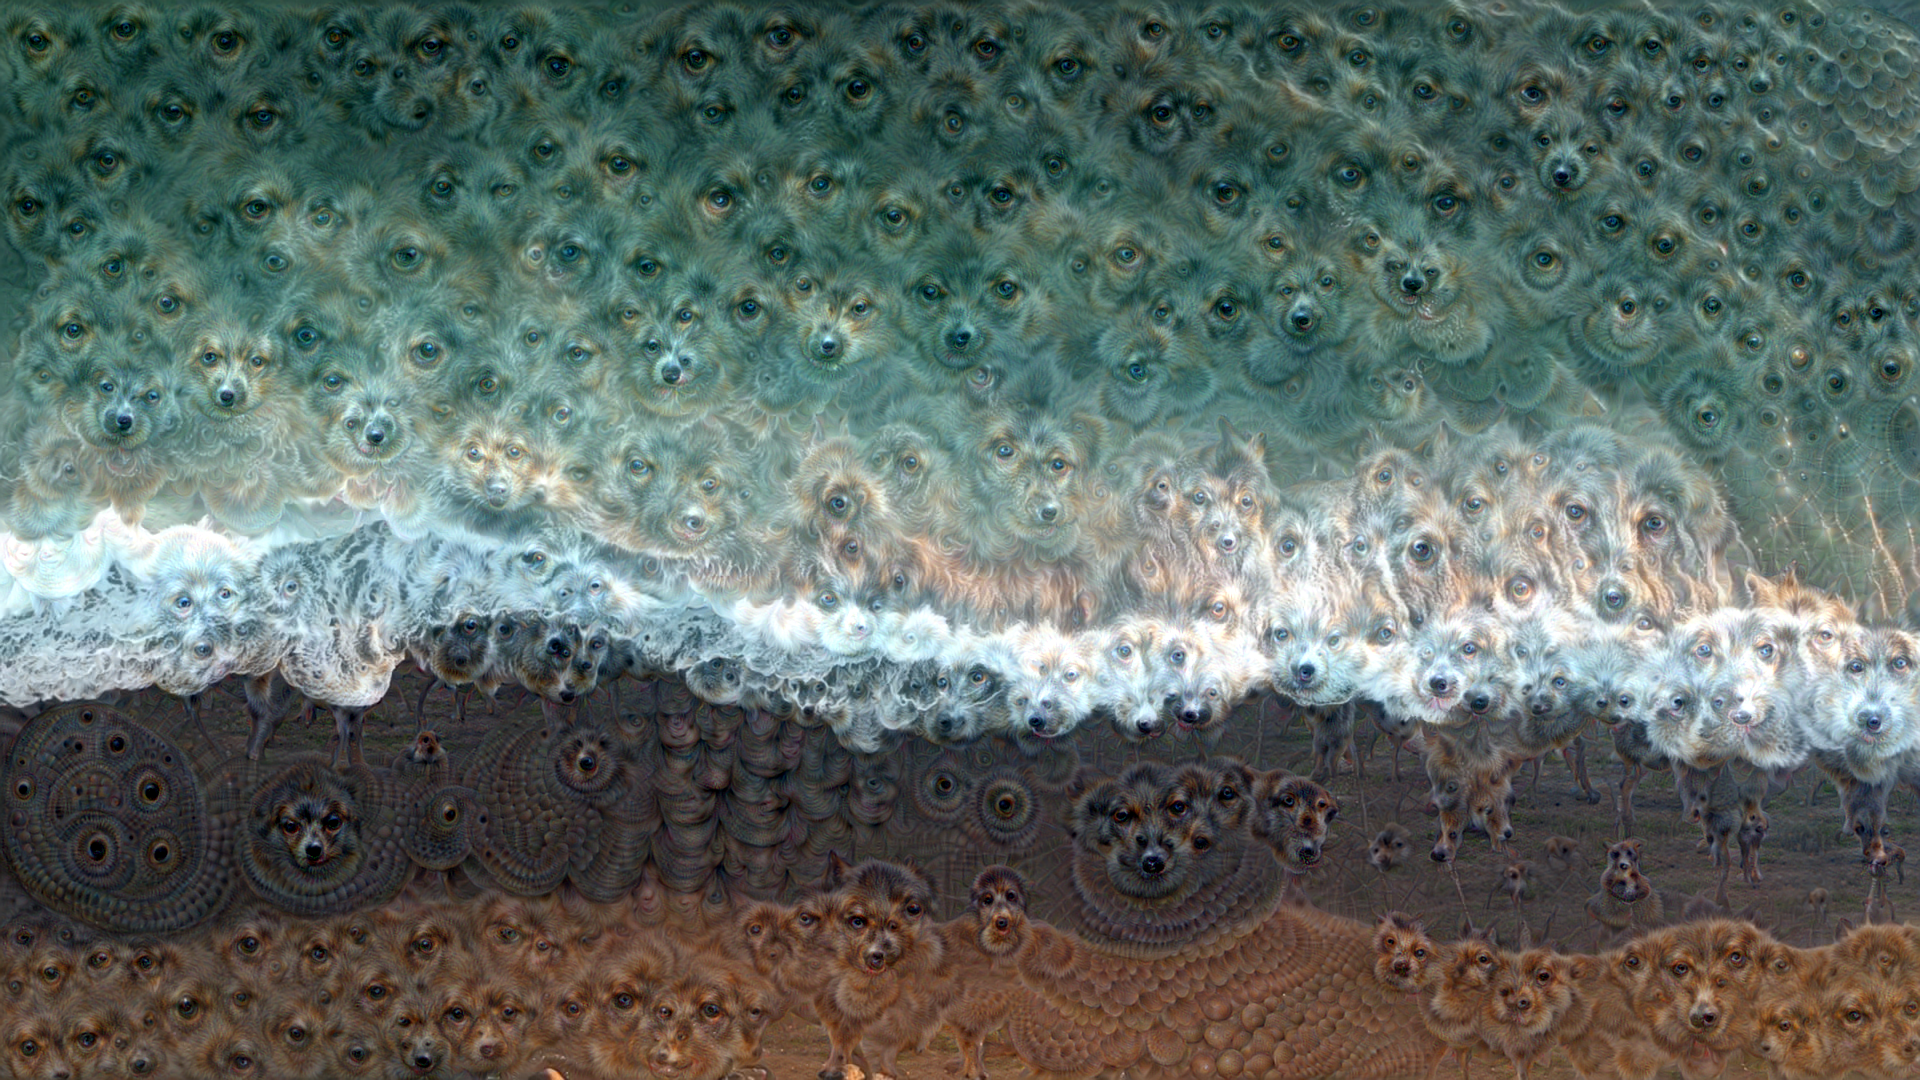

W0705 11:40:23.116026 139906709595776 <ipython-input-9-f26539ea19cf>:25] Using AVStream.codec to pass codec parameters to muxers is deprecated, use AVStream.codecpar instead.
W0705 11:40:23.154119 139906709595776 <ipython-input-10-658123cbb159>:37] Using AVStream.codec to pass codec parameters to muxers is deprecated, use AVStream.codecpar instead.


Did frame: 0
<av.VideoFrame #0, pts=0 yuv420p 1920x1080 at 0x7f3d78141648>
<av.VideoFrame #1, pts=512 yuv420p 1920x1080 at 0x7f3d90c992e8>
(1080, 1920, 3)
Recursive level: 0
Processing image: . . . . . . . . . . Recursive level: 1
Processing image: . . . . . . . . . 

W0705 11:41:05.919966 139906709595776 <ipython-input-9-f26539ea19cf>:25] Using AVStream.codec to pass codec parameters to muxers is deprecated, use AVStream.codecpar instead.


. Did frame: 1
<av.VideoFrame #0, pts=0 yuv420p 1920x1080 at 0x7f3d909ba948>
<av.VideoFrame #1, pts=1024 yuv420p 1920x1080 at 0x7f3d9094f0a8>
(1080, 1920, 3)
Recursive level: 0
Processing image: . . . . . . . . . . Recursive level: 1
Processing image: . . . . . . . . . 

W0705 11:41:48.216666 139906709595776 <ipython-input-9-f26539ea19cf>:25] Using AVStream.codec to pass codec parameters to muxers is deprecated, use AVStream.codecpar instead.


. Did frame: 2
<av.VideoFrame #0, pts=0 yuv420p 1920x1080 at 0x7f3d686a6d08>
<av.VideoFrame #1, pts=1536 yuv420p 1920x1080 at 0x7f3d686a65e8>
(1080, 1920, 3)
Recursive level: 0
Processing image: . . . . . . . . . . Recursive level: 1
Processing image: . . . . 

In [ ]:
from av.video.stream import VideoStream

input_video = 'no_key_frames.avi'



## Input video
container = get_reader(input_video)

## Ouput video
output_container, output_stream = get_writer('moshed_videos/pyav_output.mp4', width, height, fps)

temp_file = 'moshed_videos/temp_packets.mp4'

temp_output_container, tmp_strm = get_writer(temp_file, width, height, fps)

f_index = 0
for packet in container.demux():
    if packet.stream.type == 'video':
        ## I am converting every video to have only 1 key-frame
        if packet.is_keyframe:
            ## Extract full frame and deep dream
            for frame in packet.decode():
                print(frame)
                img = np.asarray(frame.to_image())
                result = transform_img(img, iterations=10, repeats=4)
                plot_image(result)
                new_frame = av.VideoFrame.from_ndarray(result, format='rgb24')
                ## Add frame to streams
                write_frame(output_container, output_stream, new_frame)
                write_frame(temp_output_container, tmp_strm, new_frame)
                
        # Every frame other than the first is not a key-frame
        else:
            ## Put p-frame into temp stream
            temp_output_container.mux_one(packet)
            temp_output_container.close()
            
            # Now read full frame from temp
            temp_input_container = av.open(temp_file, 'r')
            
            last_frame = None
            for packet in temp_input_container.demux():
                if packet.stream.type == 'video':
                    for frame in packet.decode():
                        print(frame)
                        last_frame = frame
            img = np.asarray(frame.to_image())
            print(img.shape)
            
            # Get transformed img
            result = transform_img(img, iterations=10)
            
            new_frame = av.VideoFrame.from_ndarray(result, format='rgb24')
            
            #Reopen output
            temp_output_container, tmp_strm = get_writer(temp_file, width, height, fps)
            ## Add frame to streams
            write_frame(output_container, output_stream, new_frame)
            write_frame(temp_output_container, tmp_strm, new_frame)
                
    print('Did frame:', f_index)
    f_index += 1
output_container.close()


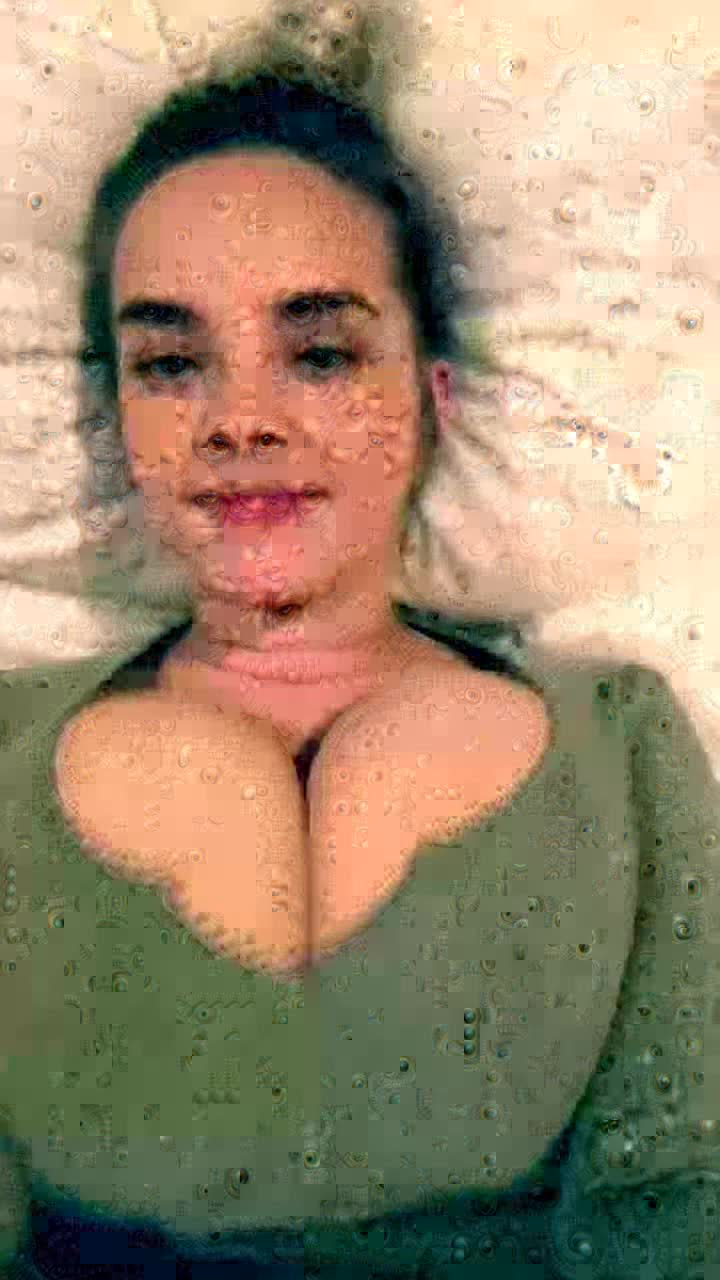

In [98]:

def get_frame_image(video, frame_num):
    file_name = 'images/frame_{}.jpeg'.format(frame_num)
    out, _ = (
        ffmpeg
        .input(video)
        .filter('select', 'gte(n,{})'.format(frame_num))
        .output(file_name, vframes=1, format='image2', vcodec='mjpeg')
        .overwrite_output()
#         .output('pipe:', vframes=1, format='image2', vcodec='mjpeg')
        .run(capture_stdout=True)
    )
#     return load_image(filename='images/frame_{}.jpeg'.format(frame_num))
    return load_image(file_name)

image = get_frame_image('moshed_videos/test_packets.mp4', 1)
plot_image(image)

In [4]:
stream = container.streams.video[0]
stream

<av.VideoStream #0 vp8, yuv420p 720x1280 at 0x7eff2fdff228>

In [ ]:
duration = 4
fps = 24
total_frames = duration * fps

container = av.open('test.mp4', mode='w')

stream = container.add_stream('mpeg4', rate=fps)
stream.width = 480
stream.height = 320
stream.pix_fmt = 'yuv420p'